In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [2]:
train_data = pl.read_csv("train_data.csv")
test_data = pl.read_csv("test_data.csv")
train_data.shape,test_data.shape

((5611, 19), (1406, 19))

In [3]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

In [4]:
calculate_vif(train_data,"Churn")

,variables,VIF
0,const,88.057918
8,MonthlyCharges,12.010306
9,TotalCharges,10.098944
5,InternetService,8.314713
4,tenure,7.142827


No high multicollinear features

In [5]:
# train_data=train_data.drop("MonthlyCharges")
# test_data=test_data.drop("MonthlyCharges")

imbalance ratio inverse

In [6]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2648369274639102

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'PaymentMethod']),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'tenure',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.648369274639102}))])

In [8]:
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

Mean Train roc auc Score: 0.8469030319944346
Mean Train recall Score: 0.7941601459215856

Mean Test roc auc Score: 0.8437113592014263
Mean Test recall Score: 0.7887062397968436


Recall score: 0.80
Correlation : 0.49509530880312747
Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.75      0.82      1031
           1       0.53      0.80      0.64       375

    accuracy                           0.76      1406
   macro avg       0.72      0.77      0.73      1406
weighted avg       0.81      0.76      0.77      1406



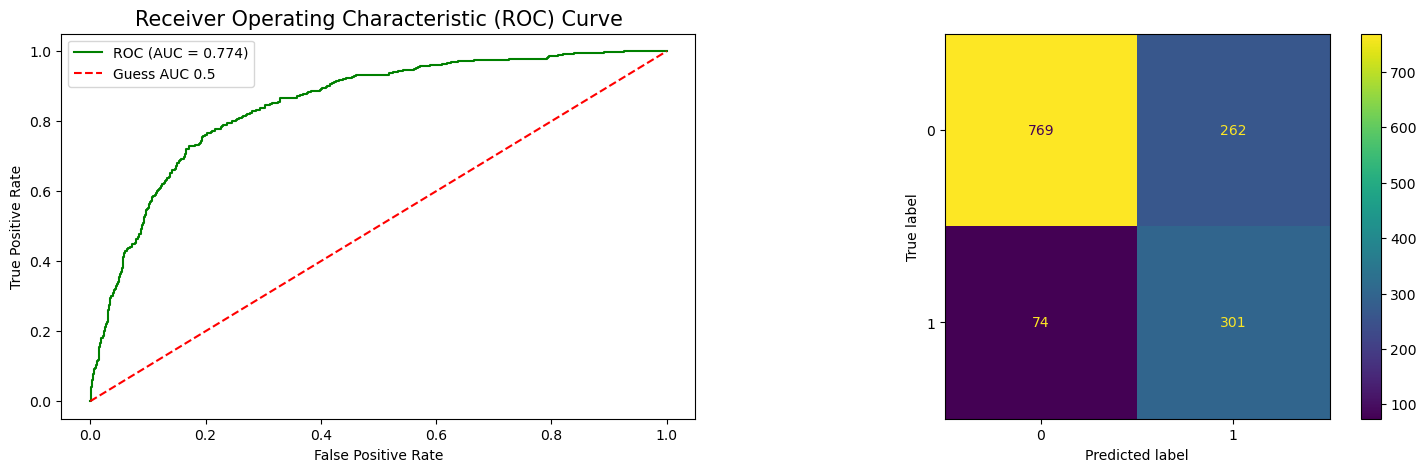

In [9]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)

80% of churners are identified with 63% precision (chance that our predicted churners are actually churners)